# ***Simulasi Software Phyton***

13222018 Dennis Hubert

13222022 I Made Medika Surya

13223048 William Anthony

In [34]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

# Jalankan Generator

In [35]:
import gan_mnist
D = gan_mnist.D
G = gan_mnist.G

# Determine the device to load models onto
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load weights with map_location
D.load_state_dict(torch.load('weights/D--300.ckpt', map_location=device))
G.load_state_dict(torch.load('weights/G--300.ckpt', map_location=device))

# Move models to the determined device
D.to(device)
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

# Membuat Image

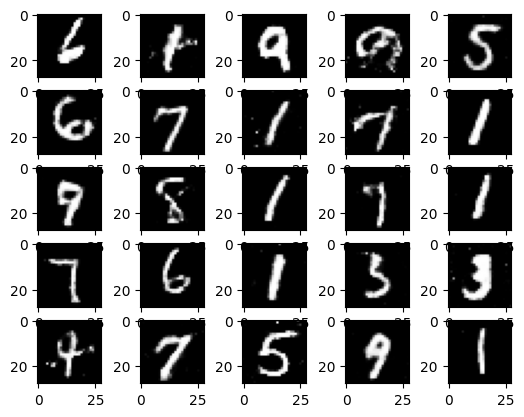

In [36]:
latent_size = 64
batch_size = 25

z = torch.randn(batch_size, latent_size).to(device)
z = Variable(z)
fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

# Jalankan Discriminator

In [37]:
outputs = D(fake_images)
print(outputs)

tensor([[0.3903],
        [0.3545],
        [0.7793],
        [0.0074],
        [0.8014],
        [0.8485],
        [0.1837],
        [0.1220],
        [0.7289],
        [0.1626],
        [0.0128],
        [0.3837],
        [0.0936],
        [0.0562],
        [0.1554],
        [0.2751],
        [0.4647],
        [0.1152],
        [0.5371],
        [0.0595],
        [0.0433],
        [0.7122],
        [0.2162],
        [0.0793],
        [0.2376]], grad_fn=<SigmoidBackward0>)


# MATLAB TRAINING

In [38]:
# export_onnx.py
import torch
import torch.onnx
import gan_mnist  # Mengimpor definisi model D dan G dari file Anda

# --- Tentukan parameter ---
latent_size = 64
image_size = 784
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Muat Model (pastikan file .ckpt ada di folder /weights) ---
D = gan_mnist.D
D.load_state_dict(torch.load('weights/D--300.ckpt', map_location=device))
D.to(device)
D.eval()

G = gan_mnist.G
G.load_state_dict(torch.load('weights/G--300.ckpt', map_location=device))
G.to(device)
G.eval()

# --- Buat Input 'Dummy' untuk Ekspor ---
dummy_input_D = torch.randn(1, image_size).to(device)
dummy_input_G = torch.randn(1, latent_size).to(device)

print("Mengekspor Diskriminator ke D.onnx...")
torch.onnx.export(D,
                  dummy_input_D,
                  "D.onnx",
                  input_names=['input_image'],
                  output_names=['score'],
                  opset_version=12,
                  dynamic_axes={'input_image': {0: 'batch_size'},
                                'score': {0: 'batch_size'}})

print("Mengekspor Generator ke G.onnx...")
torch.onnx.export(G,
                  dummy_input_G,
                  "G.onnx",
                  input_names=['input_latent'],
                  output_names=['generated_image'],
                  opset_version=12,
                  dynamic_axes={'input_latent': {0: 'batch_size'},
                                'generated_image': {0: 'batch_size'}})

print("Ekspor Selesai. File D.onnx dan G.onnx baru telah dibuat.")

Mengekspor Diskriminator ke D.onnx...
Mengekspor Generator ke G.onnx...
Ekspor Selesai. File D.onnx dan G.onnx baru telah dibuat.


/tmp/ipython-input-2323388127.py:27: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(D,
/tmp/ipython-input-2323388127.py:37: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and sh

In [39]:
# buat_resep.py
import torch
import gan_mnist
import numpy as np
from scipy.io import savemat
from torchvision.utils import save_image

# --- Parameter ---
latent_size = 64
batch_size = 8  # Kita akan buat 8 gambar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Muat Generator ---
G = gan_mnist.G
G.load_state_dict(torch.load('weights/G--300.ckpt', map_location=device))
G.to(device)
G.eval()

# --- Fungsi Denormalisasi (dari file gan_mnist.py) ---
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# --- BUAT DAN SIMPAN RESEP ---
print(f"Membuat {batch_size} resep tetap (fixed z)...")
# Kita buat 'resep' (vektor laten)
# Penting: Kita buat (batch_size, latent_size) -> (8, 64)
fixed_z = torch.randn(batch_size, latent_size).to(device)

# Ubah ke NumPy untuk disimpan
z_numpy = fixed_z.cpu().numpy()

# Simpan ke file .mat yang bisa dibaca MATLAB
savemat("fixed_z.mat", {"z_from_python": z_numpy})
print("Resep disimpan ke fixed_z.mat")

# --- Hasilkan Gambar dari Resep Ini di Python ---
fake_images = G(fixed_z)
fake_images_denorm = denorm(fake_images.view(-1, 1, 28, 28))

# Simpan gambar untuk perbandingan
save_image(fake_images_denorm, "python_fixed_output.png", nrow=4)
print("Gambar perbandingan disimpan ke python_fixed_output.png")

Membuat 8 resep tetap (fixed z)...
Resep disimpan ke fixed_z.mat
Gambar perbandingan disimpan ke python_fixed_output.png
